In [ ]:
## DISPLAY ALL nodes and edges, but remove those which are not in the filter (see movies)

    Who are the suppliers and recipients of major conventional weapons?
    What weapons have been exported or imported by specific suppliers or recipients?
    How have the relationships between different suppliers and recipients changed over time?
    Where do countries in conflict get their weapons from?
    How do states implement their export control regulations?
    Where are potentially destabilizing build ups of weapons occurring?
    What is the relationship between access to natural resources and arms transfers?

Ideas for Data dashboard:

Able to select graph and look at data inflow and outflow of each country during that time

In [2]:
import pandas as pd
import numpy as np
import os
import networkx as nx
import operator
import matplotlib.pyplot as plt
import community
%matplotlib inline  
import plotly
from plotly.graph_objs import *
import plotly.plotly as py
import math


In [3]:
import copy

# 1) Importing and linking the data

## 1.1) Reading the CSV files into seperate clean panda dataframes

In [4]:
def loadTable(directory, country_code):
    path = directory+'TIV-Import-'+country_code+'-1950-2015.csv'
    df = pd.read_csv(path)
    
    #extract current country
    to_country = df.columns.values.tolist()[0].split('TIV of arms exports to ')[1].split(', 1950-2015')[0]
    
    #downsize
    df = df.ix[9:]
    
    #get rid of column
    df = df.drop(df.columns[[0]],axis =1)
    df.columns = df.iloc[0]
    df.columns.values[0] = 'country'
    df = df.set_index((df['country']))
    df = df.drop(df.columns[0], axis=1)
    
    #take the data less the header row
    df = df[1:] 
    df.index.name = None #credit to ulynn
    df.columns.name = None
    
    # Format of the keys should be YEAR - COUNTRYFROM - COUNTRYTO --> Faster query over the years

    df.columns = df.columns.astype('str').str.replace('\.0','')
        
    df.fillna(0, inplace=True)
    try:
        df.drop(df.loc['Unknown country'].name,inplace=True)
    except:
        ""
        
    #last cleansing
    df.drop(df.index[[-1,-2]],inplace=True)
    df.drop(df.columns[-1], axis=1,inplace=True)

    return df, to_country

## 1.2) Convert one pandas dataframe into a structured dict

In [5]:
#FORMAT
#[YEARS][FROM][TO] = MONEY
def convertTableToDict(df, onecountrydict, countryTo):
    years = list(df.columns.values)
    countries = list(df.index)
    
    for year in years:
        onecountrydict.setdefault(year, dict())
        onecountrydict[year].setdefault(countryTo, dict())
        
        for country in countries:
            value = df.get_value(country, year)
            onecountrydict[year][countryTo].setdefault(country, value)
            
    return onecountrydict

In [6]:
#delete empty cells from dict

def clean_empty(d):
    if not isinstance(d, (dict, list)): #dictionairy or list
        return d
    if isinstance(d, list): 
        return [v for v in (clean_empty(v) for v in d) if v] #list comprehension
    return {k: v for k, v in ((k, clean_empty(v)) for k, v in d.items()) if v}


In [7]:
countryImportDict = dict()
PATH = '/Users/hai/Devproj/weaponstradeanalysis/data/'

countryCodeMap = dict()

for f in os.listdir(PATH):
    if not f.startswith('.'):
        if "country_codes.csv" not in f:
            countryCode = f.replace('TIV-Import-',"").replace('-1950-2015.csv', "")
            df,to_country = loadTable(PATH, countryCode)
            countryImportDict = convertTableToDict(df, countryImportDict, to_country)
            countryCodeMap.setdefault(to_country, countryCode)

countryImportDict = clean_empty(countryImportDict)

MultiDiDict = dict()
for year in countryImportDict:
    MultiDiDict.setdefault(year, dict())
    for countryImport in countryImportDict[year]:
        for countryExport in countryImportDict[year][countryImport]:
            MultiDiDict[year].setdefault(countryExport, dict())
            MultiDiDict[year][countryExport].setdefault(countryImport, 0)
            MultiDiDict[year][countryExport][countryImport] += countryImportDict[year][countryImport][countryExport]

In [8]:
df = pd.DataFrame.from_dict(countryCodeMap, orient="index")
df.sort_index(inplace=True)
df.to_csv('countrymap.csv')


# read weapon expenditure data from SIPRI beta dataset

## Read table into dataframe

In [9]:
militaryexpdf = pd.read_excel('/Users/hai/Devproj/weaponstradeanalysis/newdata/SIPRI extended milex database beta/Constant USD Beta.xlsx')
militaryexpdf = militaryexpdf.iloc[2:175, 2:]
militaryexpdf.columns = militaryexpdf.iloc[0]
militaryexpdf.columns.values[0] = 'Country'
militaryexpdf = militaryexpdf.set_index((militaryexpdf['Country']))
militaryexpdf = militaryexpdf.drop(militaryexpdf.columns[0], axis=1)
militaryexpdf = militaryexpdf[1:] 
militaryexpdf.index.name = None #credit to ulynn
militaryexpdf.columns.name = None
militaryexpdf.drop(['Montenegro'], inplace = True)


namecorrectionmapping = pd.read_csv('/Users/hai/Devproj/weaponstradeanalysis/countrymapping.csv', delimiter = ';', header = None)
namecorrectionmapping.columns = ['countrycode','newname', 'oldname']

namecorrectionmapping.set_index((namecorrectionmapping['oldname']), inplace = True)
namecorrectionmapping.drop(namecorrectionmapping.columns[[0,2]], axis=1, inplace = True)
namecorrectionmapping.index.name = None
namemappingdict = namecorrectionmapping.to_dict()


from decimal import Decimal


def convertmilitaryexpTableToDict(df,namemapping):
    years = list(df.columns.values)
    countries = list(df.index)
    militaryexpdict = dict()
    for year in years:
        militaryexpdict.setdefault(str(year), dict())
        for country in countries:
            value = df.get_value(country, year)
            if isinstance(value,float):
                value = round(Decimal(value * 0.5520917815626),1) #inflation correction from constant 2014 to constant 1990
            militaryexpdict[str(year)].setdefault((namemapping['newname'][country]), value)
    return militaryexpdict

militaryexpdict = convertmilitaryexpTableToDict(militaryexpdf, namemappingdict)

## use the manually created table to synchronize countries

In [10]:
excludedentities = pd.read_csv('excludedcountries.csv', delimiter=';', header = None)
excludedentities.columns = ['Name','Code']
excludedentities.set_index((excludedentities['Name']), inplace = True)
excludedentities.drop(excludedentities.columns[[0]], axis=1, inplace = True)
excludedentities.index.name = None
excludedentities = excludedentities.index


In [11]:
def clean_noncountries(d):
    if not isinstance(d, (dict)): #dictionairy or list
        return d
    return {k: v for k, v in ((k, clean_noncountries(v)) for k, v in d.items()) if k not in excludedentities}

## Analysis function

In [12]:
def createNeighbourGraph(G, node):
    
    newGraph = nx.Graph()
    
    for edge in G.edges(data=True):
        if edge[0] == node or edge[1] == node:
            newGraph.add_edge(edge[0],edge[1],edge[2])
    
    return newGraph

In [13]:
# most fucked up function

def addUpDict(MasterDict):

    SomethingsOverwrittenDict = copy.deepcopy(MasterDict)

    AddedUpDict = dict()

    for year in SomethingsOverwrittenDict:
        AddedUpDict.setdefault(year, dict())
        for countryExport in SomethingsOverwrittenDict[year]:
            for countryImport in SomethingsOverwrittenDict[year][countryExport]:
                AddedUpDict[year].setdefault(countryExport, dict())
                AddedUpDict[year][countryExport].setdefault(countryImport, 0)
                Richtung = SomethingsOverwrittenDict[year][countryExport][countryImport]
                #andere richtung verfügbar?
                if countryImport in SomethingsOverwrittenDict[year]:
                    if countryExport in SomethingsOverwrittenDict[year][countryImport]:
                        andereRichtung = SomethingsOverwrittenDict[year][countryImport][countryExport]
                    else: andereRichtung = 0
                else: andereRichtung = 0
                
                #Transmitting stuff into the AddedUpDict
                if (Richtung + andereRichtung) != 0:
                    AddedUpDict[year][countryExport][countryImport] = Richtung + andereRichtung

                #"Clearing the MasterDict"
                SomethingsOverwrittenDict[year][countryExport][countryImport] = 0

                if countryImport in SomethingsOverwrittenDict[year]:
                    if countryExport in SomethingsOverwrittenDict[year][countryImport]:
                        SomethingsOverwrittenDict[year][countryImport][countryExport] = 0
    
    return AddedUpDict

In [14]:
def createYearGraph(AddedUpDict, year, militaryexpdict):
    
    G = nx.Graph()    
    for countryExport in AddedUpDict[year]:
        for countryImport in AddedUpDict[year][countryExport]:
            if AddedUpDict[year][countryExport][countryImport] != 0:
                G.add_weighted_edges_from([(countryExport,countryImport,AddedUpDict[year][countryExport][countryImport])])
    
    for node in G.nodes_iter():
        if node in militaryexpdict[year]:
            G.node[node]['military expenditure'] = militaryexpdict[year][node]
        else:
            G.node[node]['military expenditure'] = 'no data'
    
    return G

In [15]:
def createYearMultiDiGraph(AddedUpDict, year,militaryexpdict):
    
    G = nx.MultiDiGraph()    
    for countryExport in AddedUpDict[year]:
        for countryImport in AddedUpDict[year][countryExport]:
            if AddedUpDict[year][countryExport][countryImport] != 0:
                G.add_weighted_edges_from([(countryExport,countryImport,AddedUpDict[year][countryExport][countryImport])])
    
    for node in G.nodes_iter():
        if node in militaryexpdict[year]:
            G.node[node]['military expenditure'] = militaryexpdict[year][node]
        else:
            G.node[node]['military expenditure'] = 'no data'
    
    return G

In [16]:
MultiDiDict = clean_empty(clean_noncountries(MultiDiDict))
AddedUpDict = clean_empty(clean_noncountries(addUpDict(MultiDiDict)))

year = '1960'

multigraph = createYearMultiDiGraph(MultiDiDict, year ,militaryexpdict)
mastergraph = createYearGraph(AddedUpDict, year , militaryexpdict)

In [17]:
sorted(nx.pagerank_numpy(mastergraph).items(), key=operator.itemgetter(1), reverse=True)[:10]

[('United States', 0.20526553677553744),
 ('Soviet Union', 0.10478705583233927),
 ('United Kingdom', 0.08429183389558412),
 ('Germany (FRG)', 0.06702907888030331),
 ('France', 0.05295981179707184),
 ('China', 0.03559242890220521),
 ('Japan', 0.02651695216565388),
 ('Switzerland', 0.02156040057991938),
 ('India', 0.01978686378117994),
 ('Turkey', 0.018682580022232508)]

In [18]:
from bokeh.charts import Bar, output_notebook, show
output_notebook()


data = pd.DataFrame(sorted(nx.betweenness_centrality(multigraph).items(), key=operator.itemgetter(1), reverse=True)[:10])
data.columns = ['country','betweenness centrality']

p = Bar(data, 'country', values='betweenness centrality', title="betweenness centrality in "+year,color='country', legend=None)

show(p)

Loading BokehJS ...

In [19]:
#nx.draw_networkx(mastergraph, pos = spring_pos, cmap = plt.get_cmap("rainbow"), node_color = bt_colors, node_size = bt_values, with_labels = False)

In [20]:
"""G = mastergraph
pos=nx.spring_layout(G)
""";

In [21]:
"""edge_trace = []

for edge in G.edges(data=True):
    countryFrom = edge[0]
    countryTo = edge[1]
    x0, y0 = pos[countryFrom]
    x1, y1 = pos[countryTo]

    edge_trace.append(
        Scatter(
            x=[x0, x1, None], 
            y=[y0, y1, None], 
            #text=[edge[2].values()[0]],
            text='skip',
            line=Line(width = (edge[2].values()[0]/100),
                      color ='#888'
                     ),
            #hoverinfo=edge[2].values()[0],
            hoverinfo='none',
            mode='lines'
        )
    )
""";

In [22]:
"""node_trace = Scatter(
    x=[], 
    y=[], 
    text=[],
    mode='markers', 
    hoverinfo='text',
    marker=Marker(
        showscale=True,
        # colorscale options
        # 'Greys' | 'Greens' | 'Bluered' | 'Hot' | 'Picnic' | 'Portland' |
        # Jet' | 'RdBu' | 'Blackbody' | 'Earth' | 'Electric' | 'YIOrRd' | 'YIGnBu'
        colorscale='YIOrRd',
        reversescale=True,
        color=[], 
        size=10,         
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=2)))

for node in G.nodes():
    x, y = pos[node]
    node_trace['x'].append(x)
    node_trace['y'].append(y)
    node_trace['text'].append(str(countryCodeMap[node]))
    
for node, adjacencies in enumerate(G.adjacency_list()):
    node_trace['marker']['color'].append(len(adjacencies))    
""";

In [23]:
"""
fig = Figure(data=Data(edge_trace+[node_trace]),
             layout=Layout(
                title='The Worlds Weapon Trade',
                titlefont=dict(size=16),
                showlegend=False, 
                width=650,
                height=650,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="Datasource: SIPRI",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=XAxis(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=YAxis(showgrid=False, zeroline=False, showticklabels=False))
            )

#py.iplot(fig, filename='weaponstrade')
""";


In [24]:
"""#Visualization from Here http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()""";

TIL kmeans is a shitty algorithm, since it only takes X and Y into account, not good for graphs

# Clustering using the louvain method

It uses the louvain method described in Fast unfolding of communities in large networks, Vincent D Blondel, Jean-Loup Guillaume, Renaud Lambiotte, Renaud Lefebvre, Journal of Statistical Mechanics: Theory and Experiment 2008(10), P10008 (12pp)

In [25]:
#first compute the best partition
partition = community.best_partition(mastergraph)

#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(mastergraph)
count = 0.

#for com in set(partition.values()) :
    #count = count + 1.
    #list_nodes = [nodes for nodes in partition.keys()
    #                            if partition[nodes] == com]
    #nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
    #                            node_color = str(count / size))
    #nx.draw_networkx_edges(G,pos, alpha=0.5)
#plt.show()

In [26]:
n = (mastergraph.number_of_nodes())/2 
part = dict([])
for node in mastergraph.nodes_iter():
    part[node] = node
ind = community.induced_graph(part, mastergraph)
goal = nx.Graph()
goal.add_weighted_edges_from([(0,1,n*n),(0,0,n*(n-1)/2), (1, 1, n*(n-1)/2)])  # NOQA

"""
#drawing
partition2 = community.best_partition(goal)
size = float(len(set(partition2.values())))
pos = nx.spring_layout(goal)
count = 0.
for com in set(partition2.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition2.keys()
                                if partition2[nodes] == com]
    nx.draw_networkx_nodes(goal, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))
    nx.draw_networkx_edges(goal,pos, alpha=0.5)
#plt.show()""";

In [27]:
colormap = dict([(0, 'rgb(91,147,204)'), (1, 'rgb(255,46,43)'),(2, 'rgb(145,58,31)'), (3, 'rgb(151,219,79)'), (4, 'rgb(41,255,25)'), (5, 'rgb(255,104,0)'), (6, 'rgb(44,20,204)'), (7, 'rgb(178,84,18)')])

In [28]:
pos3=nx.spring_layout(mastergraph, dim=3)

In [29]:
trace1 = []
for edge in mastergraph.edges(data=True):
    trace1.append(
        Scatter3d(x=[pos3[edge[0]][0],pos3[edge[1]][0], None],
                  y=[pos3[edge[0]][1],pos3[edge[1]][1], None],
                   z=[pos3[edge[0]][2],pos3[edge[1]][2], None],
                   mode='lines',
                   line=Line(color='rgb(125,125,125)',
                             width=(np.log(edge[2].values()[0])),
                             colorscale = 'Bluered'),
                   hoverinfo='none',
                   opacity=0.7
                   )
        )

trace2 = []
for node in mastergraph.nodes_iter():
    totaltrade = 0
    for edge in mastergraph.edges(data=True):
        if edge[0] == node or edge[1] == node:
            totaltrade += edge[2].values()[0]
            
    trace2.append(
        Scatter3d(x=pos3[node][0],
                  y=pos3[node][1],
                   z=pos3[node][2],
                   mode='markers',
                   name='Country',
                   marker=Marker(symbol='dot',
                                 size=np.log(totaltrade),
                                 color=colormap[partition[node]],
                                 showscale=False,
                                 cmin = 0,
                                 cmax = 4,
                                    # colorscale options
                                    # 'Greys' | 'Greens' | 'Bluered' | 'Hot' | 'Picnic' | 'Portland' |
                                    # Jet' | 'RdBu' | 'Blackbody' | 'Earth' | 'Electric' | 'YIOrRd' | 'YIGnBu'
                                 colorscale='Electric',
                                 line=Line(color='rgb(50,50,50)', width=0.5)                                 ),
                   text=str(node),
                   hoverinfo='text',
                   opacity=0.7
                   )
        )

In [30]:
axis=dict(showbackground=False,
          showline=False,
          zeroline=False,
          showgrid=True,
          showticklabels=False,
          title=''
          )

In [31]:
layout = Layout(
         title="Global Weapontrade",
         width=800,
         height=800,
         showlegend=False,
         scene=Scene(
             xaxis=XAxis(axis),
             yaxis=YAxis(axis),
             zaxis=ZAxis(axis),
        ),
    margin=Margin(
        t=100
    ),
    hovermode='closest',
    annotations=Annotations([
           Annotation(
           showarrow=False,
            text="SIPRI",
            xref='paper',
            yref='paper',
            x=0,
            y=0.1,
            xanchor='left',
            yanchor='bottom',
            font=Font(
                size=14
            )
            )
        ]),
)


In [32]:
#data=Data(trace1+trace2)
#fig=Figure(data=data, layout=layout)

#py.iplot(fig, filename='Weapontrade')

In [33]:
test = createNeighbourGraph(mastergraph, 'Germany (FRG)')

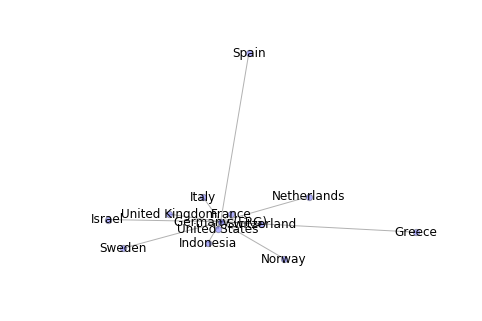

In [34]:
plt.gcf().clear()
nx.draw(test,node_size=40, alpha=0.3, node_color="blue", with_labels=True)
plt.show()
plt.rcParams['figure.figsize'] = (9, 9)

In [35]:
#completeGraph = createYearMultiDiGraph(MultiDiDict, '1990',militaryexpdict)

In [36]:
#plt.gcf().clear()
#nx.draw(completeGraph,node_size=40, alpha=0.3, node_color="blue", with_labels=False)
#plt.show()
#plt.rcParams['figure.figsize'] = (9, 9)

In [37]:
#completeGraph.edges(data = True)

In [38]:
## Analyze countries influence over time

def influenceOverTime(countrydict,country):
    influence = dict()
    for year in countrydict:
        G = createYearGraph(countrydict, year)
        valuethisyear = 0
        for entry in nx.betweenness_centrality(G).items():
            if entry[0] == country:
                valuethisyear = entry[1]
        influence[year] = valuethisyear
    return influence

# Influence Analysis

### Definition

In [39]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.io import output_notebook

from bokeh.models import ColumnDataSource,HoverTool
output_notebook()

Loading BokehJS ...

In [40]:
def influenceOverTimeAll(countrydict,militaryexpdict):
    influenceAll = dict()
    for year in countrydict:
        G = createYearGraph(countrydict, year,militaryexpdict)
        for entry in nx.betweenness_centrality(G).items():
            if entry[0] in influenceAll:
                influenceAll[entry[0]][year] = entry[1]
            else:
                influenceAll.setdefault(entry[0], dict())
                influenceAll[entry[0]][year] = entry[1]
    return influenceAll

In [41]:
def generateTimelinesPlot(influencedict, countries, name):
    from bokeh.palettes import Spectral10
    
    plot = figure(plot_width=600, plot_height=400, tools=['pan','tap','box_zoom','reset','wheel_zoom','save'])

    d = dict(x=[], y=[],country=[], color=[])
    color = copy.copy(Spectral10)
    for country in countries:
        countrycolor = color[0]
        color.remove(countrycolor)
        line = dict(xe=[], ye=[],)
        for entry in sorted(influencedict[country].items(), key=operator.itemgetter(0)):
            d['x'].append(entry[0])
            d['y'].append(entry[1])
            d['country'].append(country)
            d['color'].append(countrycolor)
            line['xe'].append(entry[0])
            line['ye'].append(entry[1])
                    
        plot.line(line['xe'], line['ye'],legend=country, color=countrycolor)
    
    s1 = plot.scatter('x', 'y', line_width=1, color = 'color', source=ColumnDataSource(d))
    plot.add_tools(HoverTool(renderers=[s1], tooltips=[('year','@x'),('country','@country'),(name,'@y')]))
    
    return plot

### Execution

In [42]:
influencedict = influenceOverTimeAll(AddedUpDict,militaryexpdict)

In [43]:
countriestoanalyze = ['Canada', 'United States', 'China', 'Myanmar']

plot = generateTimelinesPlot(influencedict,countriestoanalyze,'node centrality')

plot.yaxis.bounds = [0,1]
plot.xaxis.bounds = [1950,2015]
plot.x_range.start = 1950
plot.x_range.end = 2015
plot.y_range.start = 0
plot.y_range.end = 1

show(plot)



### Analysisfunctions, In and Outflow of Weapons

### Definition

In [44]:
def WeaponFlowTimeAll(MultiDiDict,militaryexpdict):
    weaponinflow = dict()
    weaponoutflow = dict()
    for year in MultiDiDict:
        G = createYearMultiDiGraph(MultiDiDict, year,militaryexpdict)
        for country in G.nodes_iter():
            inflow = 0
            for x in G.in_edges_iter(nbunch=country, data=True):
                inflow = inflow + x[2].values()[0]        
            if country in weaponinflow:
                weaponinflow[country][year] = inflow
            else:
                weaponinflow.setdefault(country, dict())
                weaponinflow[country][year] = inflow
                
            outflow = 0
            for x in G.out_edges_iter(nbunch=country, data=True):
                outflow = outflow + x[2].values()[0]        
            if country in weaponoutflow:
                weaponoutflow[country][year] = outflow
            else:
                weaponoutflow.setdefault(country, dict())
                weaponoutflow[country][year] = outflow
    
    return weaponinflow, weaponoutflow


In [45]:
weaponinflow, weaponoutflow = WeaponFlowTimeAll(MultiDiDict,militaryexpdict)

In [46]:
plot3 = generateTimelinesPlot(weaponinflow, ['Myanmar'], 'Weapon Inflow')

plot3.title.text = 'Weapon inflow into countries'

show(plot3)

In [47]:
plot3 = generateTimelinesPlot(weaponoutflow, ['Germany (FRG)', 'United States', 'China'],'Weapon Outflow')

show(plot3)

## New Visualization

In [48]:
from math import sqrt
from bokeh.models import ColumnDataSource

In [49]:
from bokeh.plotting import figure,show
from bokeh.io import output_notebook
from bokeh.models import HoverTool

output_notebook()
layout = nx.spring_layout(mastergraph)

Loading BokehJS ...

In [50]:
def get_nodes_specs(_network, _layout):
    d = dict(x=[], y=[], color=[], country=[], size=[], totaltrade =[], 
             cluster=[], alpha=[], largestpartner=[], military_expenditure=[])
    
    partition = community.best_partition(_network)
    
    for node in _network.nodes(data = True):
        totaltrade = 0
        largest_trade_partner_trade = 0
        largest_trade_partner_name = ''  
        
        for edge in _network.edges(data=True):
                if edge[0] == node[0] or edge[1] == node[0]:
                    totaltrade += edge[2].values()[0]
                    if edge[2].values()[0] >= largest_trade_partner_trade:
                        largest_trade_partner_trade = edge[2].values()[0]
                        if edge[0] == node[0]:
                            largest_trade_partner_name = edge[1]
                        else:
                            largest_trade_partner_name = edge[0] 

        d['x'].append(_layout[node[0]][0])
        d['y'].append(_layout[node[0]][1])
        d['color'].append(colormap[partition[node[0]]])
        d['country'].append(node[0])
        
        if isinstance(node[1].values()[0],float) and not math.isnan(node[1].values()[0]):
            d['size'].append((np.log(node[1].values()[0]))*0.8)
            d['alpha'].append(0.6)
        else:
            d['size'].append(np.log(totaltrade))
            d['alpha'].append(0.2)
        
        d['totaltrade'].append(totaltrade)
        d['cluster'].append(partition[node[0]])
        
        d['largestpartner'].append(largest_trade_partner_name)
        d['military_expenditure'].append(node[1].values()[0])
        
    return d

In [51]:
def get_edges_specs(_network, _layout):
    d = dict(xs=[], ys=[], alphas=[], width=[])
    weights = []
    for u, v, data in _network.edges(data=True):
        weights.append(data)
    max_weight = max(weights).values()
    calc_alpha = lambda h: 0.1 + 0.6 * (h / max_weight)
    for u, v, data in _network.edges(data=True):
        d['xs'].append([_layout[u][0], _layout[v][0]])
        d['ys'].append([_layout[u][1], _layout[v][1]])
        d['alphas'].append(calc_alpha(data['weight']))
        d['width'].append(np.log(data.values()[0]))
    
    return d

In [52]:
hover = HoverTool(tooltips=[('country','@country'),
                            ('cluster','@cluster'),
                            ('military expenditure','@military_expenditure'),
                            ('largest tradepartner', '@largestpartner'),
                            #('imports from', '@import'),
                            #('exports from', '@export')
                           ])

plot = figure(plot_width=800, plot_height=600, tools=['pan','tap',hover,'box_zoom','reset','wheel_zoom','save'])

layout = nx.spring_layout(mastergraph)

nodes = ColumnDataSource(get_nodes_specs(mastergraph, layout))
edges = ColumnDataSource(get_edges_specs(mastergraph, layout))

r_circles = plot.circle('x','y', source=nodes, size='size', color='color', level='overlay',alpha='alpha')
r_lines = plot.multi_line('xs', 'ys', source=edges, line_width='width', alpha='alphas', color='navy')


In [53]:
show(plot)

In [54]:
# analyze weapon trade before/during/after conflict
# weapon flow democratic vs republican leadership #germany


Deployment Scenario

In [64]:
def AllGraphs(countrydict, militaryexpdict):
    AllGraphsDict = dict()
    for year in countrydict:
        G = createYearGraph(countrydict, year, militaryexpdict)
        layout = nx.spring_layout(G)
        
        AllGraphsDict[year] = [G,layout]
        
    return AllGraphsDict

AllGraphs = AllGraphs(AddedUpDict, militaryexpdict)
nodes = dict()
edges = dict()
for year in AddedUpDict:
    nodes[year] = ColumnDataSource(get_nodes_specs(AllGraphs[year][0],AllGraphs[year][1]))
    edges[year] = ColumnDataSource(get_edges_specs(AllGraphs[year][0],AllGraphs[year][1]))
    
    
    



In [65]:
year = '1990'
nodes_source = nodes[year]
edges_source = edges[year]

In [70]:
#setup plot
hover = HoverTool(tooltips=[('country','@country'),
                            ('cluster','@cluster'),
                            ('military expenditure','@military_expenditure'),
                            ('largest tradepartner', '@largestpartner'),
                            #('imports from', '@import'),
                            #('exports from', '@export')
                           ])

plot = figure(plot_width=500, plot_height=500, tools=['pan','tap',hover,'box_zoom','reset','wheel_zoom','save'])
    
r_circles = plot.circle('x','y', source=nodes_source, size='size', color='color', level='overlay',alpha='alpha')
r_lines = plot.multi_line('xs', 'ys', source=edges_source, line_width='width', alpha='alphas', color='navy')



In [ ]:
#widgets

In [72]:
from bokeh.models.widgets import Slider
year = Slider(title="year", value=1950, start=1950, end=2015, step = 1)


In [74]:
#callbacks
def update_data(attrname, old, new):

    # Get the current slider values
    year = str(year.value)

    nodes_source = nodes[year]
    edges_source = edges[year]

year.on_change('value', update_data)

In [88]:
output_notebook()

from bokeh.layouts import row, widgetbox
from bokeh.io import curdoc, push_notebook

inputs = widgetbox(year)

curdoc().add_root(row(inputs, plot, width=1000))
curdoc().title = "Sliders"

Loading BokehJS ...

In [91]:
show(plot)


In [90]:
plot.title = "Skylon"
push_notebook()



In [ ]:
def AllGraphs(countrydict, militaryexpdict):
    AllGraphsDict = dict()
    for year in countrydict:
        G = createYearGraph(countrydict, year, militaryexpdict)
        layout = nx.spring_layout(G)
        
        AllGraphsDict[year] = [G,layout]
        
    return AllGraphsDict

AllGraphs = AllGraphs(AddedUpDict, militaryexpdict)

nodes = dict()
edges = dict()

for year in AddedUpDict:
    
    nodes[year] = ColumnDataSource(get_nodes_specs(AllGraphs[year][0],AllGraphs[year][1]))
    edges[year] = ColumnDataSource(get_edges_specs(AllGraphs[year][0],AllGraphs[year][1]))

year = Slider(title="year", value=1950, start=1950, end=2015, step = 1)

nodes_source = nodes[str(year.value)]
edges_source = edges[str(year.value)]

# Set up plot

hover = HoverTool(tooltips=[('country','@country'),
                            ('cluster','@cluster'),
                            ('military expenditure','@military_expenditure'),
                            ('largest tradepartner', '@largestpartner'),
                            #('imports from', '@import'),
                            #('exports from', '@export')
                           ])

plot = figure(plot_width=500, plot_height=500, tools=['pan','tap',hover,'box_zoom','reset','wheel_zoom','save'])
    
r_circles = plot.circle('x','y', source=nodes_source, size='size', color='color', level='overlay',alpha='alpha')
r_lines = plot.multi_line('xs', 'ys', source=edges_source, line_width='width', alpha='alphas', color='navy')

# Set up widgets

# Set up callbacks

def update_data(attrname, old, new):

    # Get the current slider values
    nodes_source = nodes[str(year.value)]
    edges_source = edges[str(year.value)]
    print year

year.on_change('value', update_data)


# Set up layouts and add to document

curdoc().add_root(row(year, plot, width=1000))
curdoc().title = "Sliders"